# 안 끝남.. 빅데이터분석 중간고사

- toc:false
- branch: master
- badges: false
- comments: false 
- author: 최서연
- categories: [Big Data Analysis]

In [17]:
from fastai.data.all import *
from fastai.vision.all import *
import torch 
from fastai.vision.all import *

### `1`. 크롤링을 통한 이미지 분석 및 CAM (40점)

#### (a) 두가지 키워드로 크롤링하여 이미지 자료를 모으고 CNN 모형을 활용하여 분석하라. 
- 2주차-hw1의 분석코드를 그대로 활용하여도 무방함

In [2]:
# collapse-hide
def search_images_ddg(key,max_n=200):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
       (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass


In [3]:
path=Path()

In [4]:
path.ls()

(#53) [Path('toenail.txt'),Path('2021-12-16-git.ipynb'),Path('2021-11-14-bd_2주차_1.ipynb'),Path('2021-11-01-데시_8주차_1.ipynb'),Path('2022-01-11-graph논문.ipynb'),Path('2021-10-12-데시_5주차.ipynb'),Path('2021-09-13-데시_2주차.ipynb'),Path('2021-12-23-ubuntu.ipynb'),Path('2021-11-21-bd_4주차_1.ipynb'),Path('2021-11-21-bd_4주차_2.ipynb')...]

In [5]:
keywords='tiger', 'lion'
path=Path('animal')

In [6]:
if not path.exists():
    path.mkdir() 
    for keyword in keywords: 
        lastpath=path/keyword 
        lastpath.mkdir(exist_ok=True) 
        urls=search_images_ddg(keyword) 
        download_images(lastpath,urls=urls)

In [7]:
verify_images(get_image_files(path))

(#0) []

In [8]:
dls=ImageDataLoaders.from_folder(
    path,
    train='animal',
    valid_pct=0.2,
    item_tfms=Resize(224))

In [9]:
learn=cnn_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.134792,0.084113,0.041096,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.204635,0.048565,0.013699,00:08
1,0.151452,0.024881,0.013699,00:08
2,0.103785,0.004312,0.000000,00:08
3,0.087895,0.001372,0.000000,00:07
4,0.068661,0.001329,0.000000,00:07
5,0.055773,0.001310,0.000000,00:08
6,0.045993,0.001617,0.000000,00:08


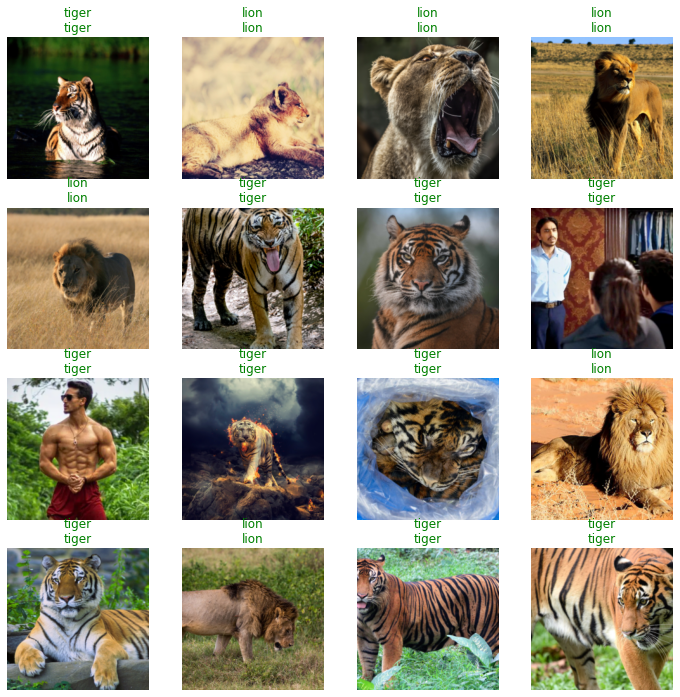

In [10]:
learn.show_results(max_n=16)

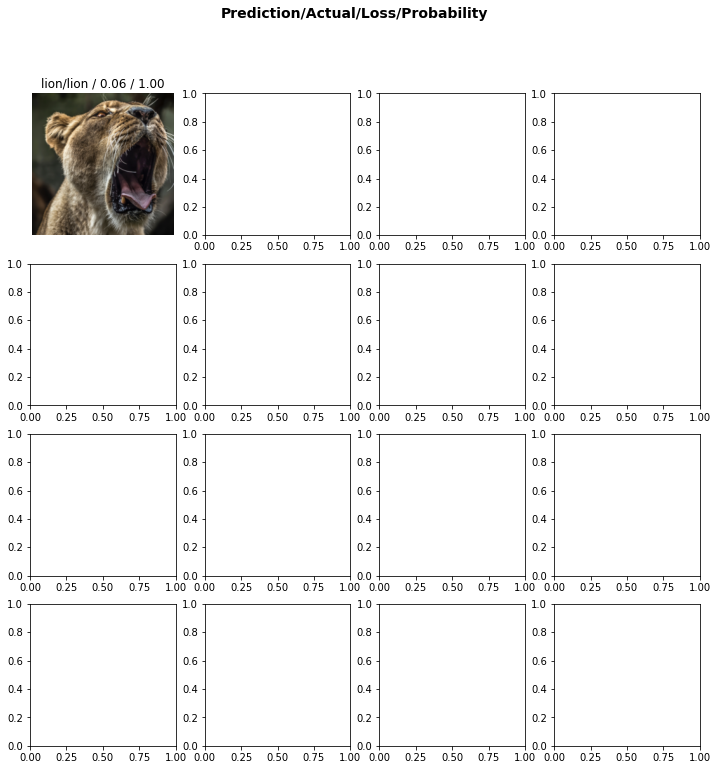

In [11]:
interp=Interpretation.from_learner(learn)
interp.plot_top_losses(16)

#### (b) CAM을 이용하여 CNN의 판단근거를 시각화하라. 

In [12]:
path

Path('animal')

In [13]:
files=get_image_files(path/'lion')

In [44]:
files[10]

Path('animal/tiger/00000050.jpg')

In [40]:
def label_func(f):
    if f[0]i>=180]:
        return 'lion' 
    else: 
        return 'tiger' 

In [ ]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [42]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate) # 34-> 작을수록 간단한 모형
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09


### `2`. 아래와 같은 5개의 자료를 관측하였다고 가정하자. (15점)

||x|y|
|:-:|:-:|:-:|
|0|11|17.7|
|1|12|18.5|
|2|13|21.2|
|3|14|23.6|
|4|15|24.2|


#### (a) 모형 $y_i=\beta_0+\beta_1 x_i$에 해당하는 네트워크를 파이토치를 이용하여 설계하고 손실함수를 정의하라. $(\beta_0,\beta_1)=(3,3)$일 경우의 loss를 계산하라. 

- 손실함수는 MSELoss를 활용한다. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [38]:
torch.manual_seed(1)
ones= torch.ones(5)
x = torch.tensor([11.0,12.0,13.0,14.0,15.0])
X = torch.vstack([ones,x]).T
y = torch.tensor([17.7,18.5,21.2,23.6,24.2])
w0=3.0
w1=3.0
u=w0+X*w1
v=torch.exp(u)/(1+torch.exp(u))

In [39]:
x,X,u,v,y

(tensor([11., 12., 13., 14., 15.]),
 tensor([[ 1., 11.],
         [ 1., 12.],
         [ 1., 13.],
         [ 1., 14.],
         [ 1., 15.]]),
 tensor([[ 6., 36.],
         [ 6., 39.],
         [ 6., 42.],
         [ 6., 45.],
         [ 6., 48.]]),
 tensor([[0.9975, 1.0000],
         [0.9975, 1.0000],
         [0.9975, 1.0000],
         [0.9975, 1.0000],
         [0.9975, 1.0000]]),
 tensor([17.7000, 18.5000, 21.2000, 23.6000, 24.2000]))

In [40]:
net=torch.nn.Linear(in_features=2,out_features=1,bias=False) 
net.weight.data= torch.tensor([[3.0,3.0]]) 
yhat=net(X) 
lossfn=torch.nn.MSELoss() 
loss=lossfn(y.reshape(5,1),yhat) 
loss 

tensor(442.4360, grad_fn=<MseLossBackward0>)

#### (b) $(\beta_0,\beta_1)=(3,3)$에서 손실함수의 미분계수를 계산하라. 

In [41]:
X.T @ -torch.eye(5)@ (2*v) / 5 

tensor([[ -1.9951,  -2.0000],
        [-25.9357, -26.0000]])

#### (c) 경사하강법을 통하여 $(\beta_0,\beta_1)=(3,3)$의 값을 1회 update하라. 여기에서 학습률은 0.01로 설정한다. 

In [42]:
loss.backward()

In [43]:
net.weight.grad

tensor([[ 41.9200, 549.7200]])

In [44]:
net.weight.data

tensor([[3., 3.]])

In [45]:
optmz= torch.optim.SGD(net.parameters(),lr=0.01)

In [46]:
optmz.step()

In [47]:
net.weight.data

tensor([[ 2.5808, -2.4972]])

In [48]:
loss

tensor(442.4360, grad_fn=<MseLossBackward0>)

### `3`. 파이토치를 이용한 모형구축 및 학습 (20점) 

아래와 같은 모형에서 시뮬레이션 된 자료가 있다고 하자. 

$$y_i= \beta_0 + \beta_1 \exp(-x_i)+ \epsilon_i$$

여기에서 $\epsilon_i \overset{iid}\sim N(0,0.1^2)$ 이다. 시뮬레이션된 자료는 아래의 코드를 통하여 얻을 수 있다.

In [49]:
import pandas as pd 
df=pd.read_csv('https://raw.githubusercontent.com/guebin/2021BDA/master/_notebooks/2021-11-06-prob3.csv')
df.head()

,x,y
0,0.0,4.962202
1,0.1,4.889815
2,0.2,4.605782
3,0.3,4.491711
4,0.4,4.344537


자료를 시각화 하면 아래와 같다. 

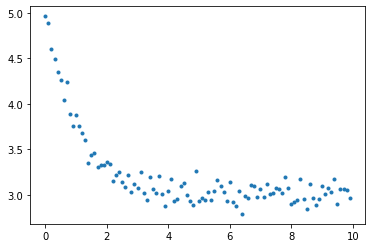

In [50]:
plt.plot(df.x,df.y,'.')

파이토치를 이용하여 적절한 $\beta_0, \beta_1$의 값을 구하여라. (손실함수는 MSEloss를 사용한다.) 

In [80]:
X=torch.tensor([df.x]).reshape(100,1)
y=torch.tensor([df.y]).reshape(100,1)
w0=1.0
w1=10.0
u=w0+X*w1
v=torch.exp(u)/(1+torch.exp(u))

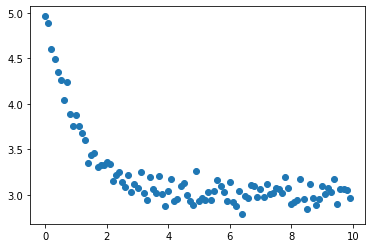

In [87]:
_w0=np.arange(-10,3,0.05) # start=-10, stop=3, step=0.05
_w1=np.arange(-1,10,0.05)

In [ ]:
_w0,_w1=np.meshgrid(_w0,_w1,indexing='ij') # grid를 array로 만들기

In [ ]:
def lossfn_mse(w0,w1): 
    yhat=torch.exp( w0+w1*X) / (1+torch.exp( w0+w1*X))
    loss= torch.mean((y-yhat)**2) 
    return loss.tolist()

In [ ]:
_l=list(map(lossfn_mse,_w0,_w1))

In [ ]:
_w0[np.argmin(_l)],_w1[np.argmin(_l)] # 실제 값이랑 비슷

In [ ]:
l1=torch.nn.Linear(in_features=1,out_features=1,bias=True)
a1=torch.nn.Sigmoid()
net=torch.nn.Sequential(l1,a1) 
optimizer=torch.optim.SGD(net.parameters(),lr=0.05) 

In [ ]:
l1.bias.data, l1.weight.data

### `4`. 다음을 잘 읽고 물음에 O/X로 답하라. (25점)

`(1)` 경사하강법은 손실함수와 상관없이 언제나 전역최소해를 찾을 수 있다. 

X
- 손실함수 모양이 convex인 경우에만

`(2)` 확률적경사하강법은 손실함수와 상관없이 언제 전역최소해를 찾을 수 있다. 

X
- 손실함수 모양이 convex인 경우에만

`(3)` 일반근사정리(universal approximation theorem)는 충분히 깊은 신경망이 어떠한 함수든 표현할 수 있다는 내용의 이론이다. 

X
- 넓은 신경망에 대한 이론, 모든 함수 표현 가능, 특정 함수는 아님

`(4)` $y_i=\beta_0+\beta_1 x_i+\epsilon_i$ 와 같은 형태의 단순회귀모형은 학습해야할 파라메터가 2개이다. 

O
- $\beta_0$, $\beta_1 $ 2개

`(5)` 참모형(true model)이 단순회귀모형일 경우, 비선형 활성화 함수를 사용한 깊은신경망으로 모형을 적합시키면 오히려 적합력이 떨어진다. 

X
- x,y가 일반화되어있을떄는 비선형 활성화 함수(sigmoid, relu 등 MLP) 적합력은 올라가지만 overfitting issue가 생긴다.
- 파라메터 수, 즉 모형의 표현력이 증가하면 적합력이 올라감

`(6)` 확률적 경사하강법은 관측자료에 임의의 오차항을 더하여 학습시키는 방법이다. 

x
- 전체에서 미니배치로 나눠서 미니배치를 순서대로 학습하는 방법

`(7)` 경사하강법은 손실함수가 convex일 경우 언제나 전역최소해를 찾을 수 있다. 

O

`(8)` 로지스틱 모형에서 MSEloss를 사용하더라도 전역최소해를 찾는 경우가 있다. 즉 시그모이드 활성화 함수와 MSEloss를 사용한다고 하여도 항상 전역최소해를 찾지 못하는 것은 아니다. 

O
- sigmoid가 적절한

`(9)` 로지스틱 모형에서 MSELoss를 사용하면 옵티마이저를 Adam으로 선택하고 BCELoss를 사용하면 확률적 경사하강법을 사용한다. 

X
- Adam은 확률적 경사하강법을 개량시킨 것이기 떄문에 Adam을 쓰면 수렴이 잘 되고 optimizer 선택해야하는 rule은 없음

`(10)` 확률적 경사하강법은 컴퓨터의 자원을 효율적으로 활용할 수 있도록 도와준다. 

O
- 우리가 주로 쓰는 gpu, memory가 중요
- observation만 바꿔서 학습하는 방법 뭐지, 미니배치를 활용한 확률적 경사하강법
- 컴퓨터 자원을 효율적으로 활용할 수 있기 위해 나온 건 아니고 도와준다.

`(11)` 학습할 파라메터가 많을수록 GPU의 학습속도가 CPU의 학습속도 보다 빠르다. 

O

`(12)` GPU는 언제나 CPU보다 빠르게 모형을 학습한다. 

X

`(13)` CNN 모형에서 에서 2D콘볼루션은 비선형 변환이다. 

X
- 선형 변환

`(14)` 드랍아웃은 결측치를 제거하는 기법이다. 

X

`(15)` 모든 관측치를 활용하지 않고 일부의 관측치만 활용하여 학습하는 기법을 드랍아웃이라 한다. 

X
- 디자인 매트릭스 n * p 중 n에 일부를 버리진 않음.
- 오히려 이 문항은 미니배치와 적절>

`(16)` 확률적 경사하강법은 드랍아웃과 같이 사용할 수 없다. 

X
- 경사하강법은 optimizer에 사용, dropout은 아키텍쳐 단계.

`(17)` MLP의 모든 활성화 함수가 선형이라면 은닉층(Hidden Layer)을 아무리 추가하여도 모형의 표현력이 향상되지 않는다. 

O

`(18)` 학습할 파라메터수가 증가하면 언더피팅의 위험이 있다. 

X
- overfitting의 위험

`(19)` CAM은 CNN의 모든층에서 사용가능하다. 

X
- 최종 아웃풋에서만 시각화할 수 있음

`(20)` CAM은 CNN모형의 일부를 수정해야 한다는 점에서 단점이 있다. 

O

`(21)` CNN은 이미지 자료만 분석할 수 있다. 

X
- array 형태로 저장할 수 있는 자료에 특화되어 있음, 2d형태에 사용 가능

`(22)` 드랍아웃은 과적합을 방지하는 효과가 있다. 

O

`(23)` 예측 및 적합을 할때는 네트워크에서 드랍아웃층을 제거해야 한다. 

O

`(24)` BCELoss는 Softmax 활성화 함수와 잘 어울린다. 

X
- Sigmoid
- Softmax는 Cross Entropy Loss

`(25)` 파이토치에서 미분을 수행하는 메소드는 backward() 이다. 

O